## The environment

First, we define a simple `Transaction` class, as these are the base element of our simulation. Users produce transactions, which are sent to block producers who must select which of these transactions to include. Under EIP 1559, users specify two things:

- The _gas premium_, i.e., the "tip" to the block producers.
- The _fee cap_, i.e., the highest gas price they are willing to pay.

As before, users also specify a gas limit for their transaction. If the transaction ends up consuming more gas than the specified gas limit, it is reverted without changes to the chain.

In [1]:
import secrets
import pandas as pd

class Transaction:
    def __init__(self, gas_premium, fee_cap, gas_used):
        self.gas_premium = gas_premium
        self.fee_cap = fee_cap
        self.gas_used = gas_used
        self.tx_hash = secrets.token_bytes(8)
        
    def __lt__(self, other):
        return self.gas_premium < other.gas_premium

In [2]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 10000000,
    "MAX_GAS_EIP1559": 16000000,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
    "PER_TX_GASLIMIT": 8000000

}

In [3]:
class Block():
    def __init__(self, txs):
        self.txs = txs

In [4]:
def is_valid(tx, basefee):
    return tx.fee_cap >= basefee

In [5]:
from random import uniform

def update_demand_scenario(timestep, demand, tx_scenario):
    for i in range(tx_scenario[timestep]):
        gas_premium = uniform(1, 11) * (10 ** 9)
        fee_cap = gas_premium + uniform(1, 11) * (10 ** 9)
        tx = Transaction(
            gas_premium = gas_premium,
            gas_used = 21000,
            fee_cap = fee_cap
        )
        demand[tx.tx_hash] = tx
        
    return demand

In [6]:
def include_valid_txs(demand, basefee):
    sorted_valid_demand = sorted([tx for tx_hash, tx in demand.items() if is_valid(tx, basefee)], key = lambda tx: -tx.gas_premium)
    included_transactions = sorted_valid_demand[0:570]
    
    return Block(txs = included_transactions)

In [7]:
def update_basefee(block, basefee):
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    new_basefee = basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    return new_basefee

In [8]:
def remove_included_txs(demand, latest_block):
    for tx in latest_block.txs:
        del(demand[tx.tx_hash])

    return demand

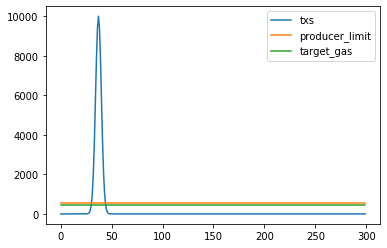

In [9]:
from math import pow, exp

timesteps = 300

def generate_spike_scenario(timesteps):
    spikey_boi = timesteps // 8
    return [int(10000 * exp(-pow(i - spikey_boi, 2)/16.0)) for i in range(timesteps)]

tx_scenario = generate_spike_scenario(timesteps)
pd.DataFrame({ "txs": tx_scenario, "producer_limit": 570, "target_gas": 476 }).plot()

In [10]:
T = timesteps

basefee = 5 * (10 ** 9)
demand = {}
latest_block = Block(txs = [])
rows = [{ "timestep": 0, "basefee": basefee, "demand": demand, "latest_block": latest_block }]

for timestep in range(T):
    demand = update_demand_scenario(timestep, demand, tx_scenario)
    latest_block = include_valid_txs(demand, basefee)
    basefee = update_basefee(latest_block, basefee)
    demand = remove_included_txs(demand, latest_block)
    rows += [{ "timestep": timestep, "basefee": basefee, "demand": demand.copy(), "latest_block": latest_block }]
    
df = pd.DataFrame(rows)

In [11]:
df.head()

,timestep,basefee,demand,latest_block
0,0,5000000000,{},<__main__.Block object at 0x11a3a4a58>
1,0,4375000000,{},<__main__.Block object at 0x11a3a4ba8>
2,1,3828125000,{},<__main__.Block object at 0x11a3a49b0>
3,2,3349609375,{},<__main__.Block object at 0x11a3a4208>
4,3,2930908203,{},<__main__.Block object at 0x11a3a4048>


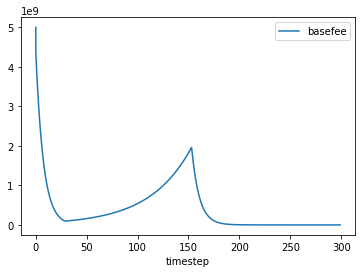

In [12]:
df.plot("timestep", "basefee")